# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=http://www.datascience-paris-saclay.fr/en/site/newsView/12>RAMP</a> on predicting the number of air passengers

### <i> Repport <u>Fabrice ZAPFACK </u> </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
* the date of departure
* the departure airport
* the arrival airport
* the mean and standard deviation of the number of weeks of the reservations made before the departure date
* a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. **The challenge in this RAMP is to find good data that can be correlated to flight traffic**.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [3]:
# optional
import seaborn as sns; sns.set()

## Fetch the data and load it in pandas

In [4]:
data = pd.read_csv("data/public/public_train.csv")

## Data exploration

In [5]:
print min(data['DateOfDeparture'])
print max(data['DateOfDeparture'])

2011-09-01
2013-03-05


In [6]:
print data.shape # 5 five variables
data.head()

(11128, 6)


,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd
0,2012-10-21,DFW,SFO,14.600000,10.757779,11.575837
1,2012-09-13,LAX,ATL,14.730769,11.808097,13.364304
2,2012-09-04,ORD,IAH,8.470588,10.865349,5.885551
3,2012-08-13,DEN,PHX,8.200000,10.710562,6.292853
4,2012-09-10,ORD,SEA,12.090909,11.498355,9.138662


In [7]:
print data['Departure'].unique()
print data['Arrival'].unique() # Same airports

['DFW' 'LAX' 'ORD' 'DEN' 'MCO' 'IAH' 'MIA' 'ATL' 'LGA' 'SEA' 'PHX' 'CLT'
 'DTW' 'LAS' 'EWR' 'MSP' 'BOS' 'PHL' 'SFO' 'JFK']
['SFO' 'ATL' 'IAH' 'PHX' 'SEA' 'PHL' 'ORD' 'JFK' 'DTW' 'MSP' 'CLT' 'BOS'
 'MIA' 'DEN' 'LAX' 'LAS' 'EWR' 'LGA' 'DFW' 'MCO']


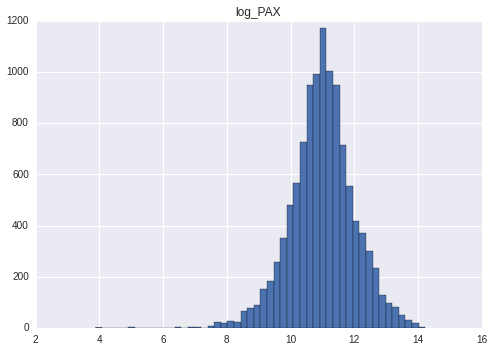

In [8]:
data.hist(column='log_PAX', bins=50); # Loi gaussienne moyenne 11

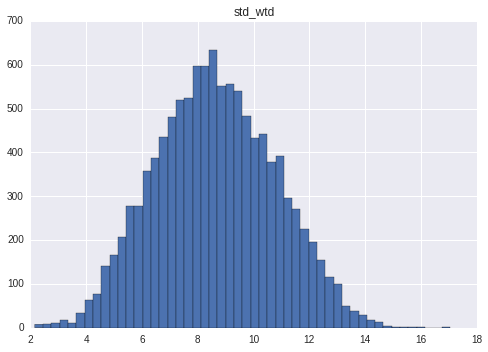

In [9]:
data.hist('std_wtd', bins=50);

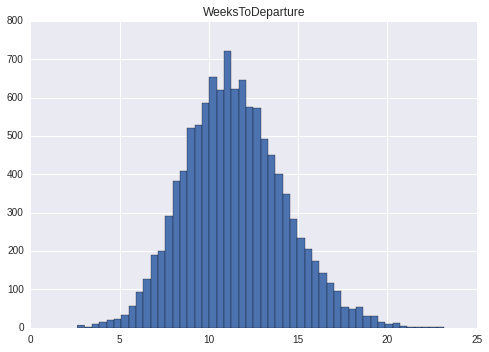

In [10]:
data.hist('WeeksToDeparture', bins=50);

The variable we have to predict seems to be gaussian (mean~=11 and std~=1).
'WeeksToDeparture' and 'std_wtd' also have gaussian shape => perfect 

In [11]:
print data.shape
print data['log_PAX'].mean()
print data['log_PAX'].std()
data.describe() 
# We don't numerical missing values (if there are missing values for categorical variables dummy code will deal)

(11128, 6)
10.9977280345
0.99824195459


,WeeksToDeparture,log_PAX,std_wtd
count,11128.000000,11128.000000,11128.000000
mean,11.466842,10.997728,8.635226
std,2.807131,0.998242,2.145805
min,2.625000,3.878108,2.160247
25%,9.523810,10.427055,7.109619
50%,11.304348,11.008268,8.582272
75%,13.259259,11.590093,10.162525
max,23.163265,14.224277,17.035677


In [12]:
data.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
log_PAX             float64
std_wtd             float64
dtype: object

## Features Engineering

### Create of a feature by aggregating others one

In [13]:
## We create a new feature that represents a flight (LAX -> ATL for example)
data['Flight'] = zip(data['Departure'].values,data['Arrival'].values)
data.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,Flight
0,2012-10-21,DFW,SFO,14.600000,10.757779,11.575837,"(DFW, SFO)"
1,2012-09-13,LAX,ATL,14.730769,11.808097,13.364304,"(LAX, ATL)"
2,2012-09-04,ORD,IAH,8.470588,10.865349,5.885551,"(ORD, IAH)"
3,2012-08-13,DEN,PHX,8.200000,10.710562,6.292853,"(DEN, PHX)"
4,2012-09-10,ORD,SEA,12.090909,11.498355,9.138662,"(ORD, SEA)"


### Preprocessing for prediction

Getting dates into numerical columns is a common operation when time series are analyzed with non-parametric predictors. The code below makes all possible choices: ordered columns for the year, month, day, weekday, week, and day in the year, and one-hot columns for year month, day, weekday, and week.

The departure and arrival airports are also converted into one-hot columns. 

**We also perfommed scaling and replacement of missing values by the mean**

In [14]:
def encode_data(data):
    data_encoded = data
    #Some models (SVM, Linearegressor, ...) can not deal with categorial variables that's the reasonwe performed dummy tranform
    #We verified that this operation does not decrease performance of others models like random forests
    data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Departure'], prefix='d'))
    data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Arrival'], prefix='a'))
    data_encoded = data_encoded.drop('Departure', axis=1)
    data_encoded = data_encoded.drop('Arrival', axis=1)
    
    data_encoded = data_encoded.join(pd.get_dummies(data_encoded['Flight'], prefix='f'))
    data_encoded = data_encoded.drop('Flight', axis=1)

    # following http://stackoverflow.com/questions/16453644/regression-with-date-variable-using-scikit-learn
    data_encoded['DateOfDeparture'] = pd.to_datetime(data_encoded['DateOfDeparture'])
    data_encoded['year'] = data_encoded['DateOfDeparture'].dt.year
    data_encoded['month'] = data_encoded['DateOfDeparture'].dt.month
    data_encoded['day'] = data_encoded['DateOfDeparture'].dt.day
    data_encoded['weekday'] = data_encoded['DateOfDeparture'].dt.weekday
    data_encoded['week'] = data_encoded['DateOfDeparture'].dt.week
    data_encoded['n_days'] = data_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

    # For some reason dummy code weekday and 'day' make decrease prediction performance slightly
    data_encoded = data_encoded.join(pd.get_dummies(data_encoded['year'], prefix='y'))
    data_encoded = data_encoded.join(pd.get_dummies(data_encoded['month'], prefix='m'))
    data_encoded = data_encoded.join(pd.get_dummies(data_encoded['day'], prefix='d'))
    data_encoded = data_encoded.join(pd.get_dummies(data_encoded['weekday'], prefix='wd'))
    data_encoded = data_encoded.join(pd.get_dummies(data_encoded['week'], prefix='w'))
#     data_encoded = data_encoded.drop('year', axis=1)
#     data_encoded = data_encoded.drop('month', axis=1)
#     data_encoded = data_encoded.drop('day', axis=1)
#     data_encoded = data_encoded.drop('week', axis=1)
    data_encoded = data_encoded.drop('DateOfDeparture', axis=1)
    return data_encoded

def preprocess(data):
    for i in data.dtypes[data.dtypes!='object'].index:
            a = data[i].values
            a[np.isnan(a)] = np.mean(a)
            data[i] = (a-np.mean(a))/np.std(a)
    return data

### Adding External data
We have some external data that are given and can give some information for our prediction task
We also foud some information on the website http://www.rita.dot.gov/
The only information we decided to keep is the distances between airports

In [15]:
## Let's start with the distances dataset
import os
path = '.'
dist_df = pd.read_csv(os.path.join(path, "Submission/dist_data.csv"))#we have 1145 airports in this dataset
print [i in dist_df.DEST.unique() for i in data['Departure'].unique()] #All the airports are in the dataset
dist_df = dist_df.drop_duplicates()
dist_df = dist_df.rename(columns={'ORIGIN': 'Departure', 'DEST': 'Arrival'})
data2 = pd.merge(data,dist_df,how='left', on=['Departure', 'Arrival'])
data2.tail()# No missing values

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,Flight,DISTANCE
11123,2011-11-22,IAH,LAX,11.636364,10.334322,8.888438,"(IAH, LAX)",1379
11124,2011-12-14,ORD,DFW,13.541667,12.459632,10.341891,"(ORD, DFW)",802
11125,2013-01-28,CLT,LGA,5.583333,11.381124,3.752777,"(CLT, LGA)",544
11126,2011-09-03,LAS,LAX,12.730769,11.308812,7.997788,"(LAS, LAX)",236
11127,2012-09-24,DEN,SFO,14.250000,11.619697,9.508768,"(DEN, SFO)",967


In [17]:
## This dataset countains 22 extra features
X_weather = pd.read_csv(os.path.join(path, "Submission/external_data2.csv"))
X_weather = X_weather[['Date', 'AirPort','Max VisibilityKm']]
X_weather = X_weather.rename(columns={'Date': 'DateOfDeparture', 'AirPort': 'Departure'})
data3 = pd.merge(data2,X_weather,how='left', on=['DateOfDeparture', 'Departure'])
print data3.shape
data3.tail()# No missing values

(11128, 9)


,DateOfDeparture,Departure,Arrival,WeeksToDeparture,log_PAX,std_wtd,Flight,DISTANCE,Max VisibilityKm
11123,2011-11-22,IAH,LAX,11.636364,10.334322,8.888438,"(IAH, LAX)",1379,16
11124,2011-12-14,ORD,DFW,13.541667,12.459632,10.341891,"(ORD, DFW)",802,16
11125,2013-01-28,CLT,LGA,5.583333,11.381124,3.752777,"(CLT, LGA)",544,16
11126,2011-09-03,LAS,LAX,12.730769,11.308812,7.997788,"(LAS, LAX)",236,16
11127,2012-09-24,DEN,SFO,14.250000,11.619697,9.508768,"(DEN, SFO)",967,16


Some of those new features were only adding noise in the prediction. 
To select the useful features, we ran our best model multiples times and going form the largest dataset, we checked if the removal of a given feature will make the error obtained by cross validation increase or decrease

In [16]:
%%time
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
data3 = preprocess(data3)
data_encoded = encode_data(data3)
features = data_encoded.drop(['log_PAX'], axis=1)
X_columns = data_encoded.columns.drop(['log_PAX'])
X = features.values
y = data_encoded['log_PAX'].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)
# reg = GradientBoostingRegressor(n_estimators=50, max_depth=8,random_state=50)
reg = RandomForestRegressor(n_estimators=30, max_depth=40, max_features=55)
scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores)))) #Slight increase of perfomance

log RMSE: 0.4130 +/-0.0210
CPU times: user 3.68 s, sys: 136 ms, total: 3.82 s
Wall time: 27.1 s


### Storing external data in 1 file

In [14]:
import os
path = '.'
dist_df = pd.read_csv(os.path.join(path, "Submission/dist_data.csv"))
dist_df = dist_df.drop_duplicates()
dist_df = dist_df.rename(columns={'ORIGIN': 'Departure', 'DEST': 'Arrival'})
X_weather = pd.read_csv(os.path.join(path, "Submission/external_data2.csv"))
# X_weather = X_weather[['Date', 'AirPort', 'Dew PointC','Max Humidity']]
X_weather = X_weather[['Date', 'AirPort', 'Max VisibilityKm']]
X_weather = X_weather.rename(columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
ext_df = pd.merge(dist_df,X_weather,how='inner', on=['Arrival'])
ext_df.head()

ext_df.to_csv("Submission/external_data.csv",index=False)

### Combining all preprocessing

In [16]:
ext_df = pd.read_csv(os.path.join(path, "Submission/external_data.csv"))
ext_df.head()
data2 = pd.merge(data,ext_df,how='left', on=['DateOfDeparture','Arrival','Departure'])
data2 = preprocess(data2)
data_encoded = encode_data(data2)
print data_encoded.shape
data_encoded.tail(5)

(11128, 282)


,WeeksToDeparture,log_PAX,std_wtd,DISTANCE,Max VisibilityKm,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,"f_('ATL', 'BOS')","f_('ATL', 'CLT')","f_('ATL', 'DEN')","f_('ATL', 'DFW')","f_('ATL', 'DTW')","f_('ATL', 'EWR')","f_('ATL', 'LAX')","f_('ATL', 'LGA')","f_('ATL', 'MCO')","f_('ATL', 'MIA')","f_('ATL', 'MSP')","f_('ATL', 'ORD')","f_('ATL', 'PHL')","f_('ATL', 'SFO')","f_('BOS', 'ATL')","f_('BOS', 'EWR')","f_('BOS', 'LAX')","f_('BOS', 'LGA')","f_('BOS', 'ORD')","f_('BOS', 'PHL')","f_('BOS', 'SFO')","f_('CLT', 'ATL')","f_('CLT', 'LGA')","f_('DEN', 'ATL')","f_('DEN', 'DFW')","f_('DEN', 'LAS')","f_('DEN', 'LAX')","f_('DEN', 'MSP')","f_('DEN', 'ORD')","f_('DEN', 'PHX')","f_('DEN', 'SEA')","f_('DEN', 'SFO')","f_('DFW', 'ATL')","f_('DFW', 'BOS')","f_('DFW', 'DEN')","f_('DFW', 'LAS')","f_('DFW', 'LAX')","f_('DFW', 'LGA')","f_('DFW', 'ORD')","f_('DFW', 'PHL')","f_('DFW', 'SFO')","f_('DTW', 'ATL')","f_('DTW', 'LGA')","f_('DTW', 'ORD')","f_('EWR', 'ATL')","f_('EWR', 'BOS')","f_('EWR', 'LAX')","f_('EWR', 'MCO')","f_('EWR', 'ORD')","f_('EWR', 'SFO')","f_('IAH', 'LAX')","f_('IAH', 'ORD')","f_('JFK', 'LAS')","f_('JFK', 'LAX')","f_('JFK', 'MCO')","f_('JFK', 'MIA')","f_('JFK', 'SFO')","f_('LAS', 'DEN')","f_('LAS', 'DFW')","f_('LAS', 'JFK')","f_('LAS', 'LAX')","f_('LAS', 'ORD')","f_('LAS', 'SFO')","f_('LAX', 'ATL')","f_('LAX', 'BOS')","f_('LAX', 'DEN')","f_('LAX', 'DFW')","f_('LAX', 'EWR')","f_('LAX', 'IAH')","f_('LAX', 'JFK')","f_('LAX', 'LAS')","f_('LAX', 'ORD')","f_('LAX', 'SEA')","f_('LAX', 'SFO')","f_('LGA', 'ATL')","f_('LGA', 'BOS')","f_('LGA', 'CLT')","f_('LGA', 'DFW')","f_('LGA', 'DTW')","f_('LGA', 'MIA')","f_('LGA', 'ORD')","f_('MCO', 'ATL')","f_('MCO', 'EWR')","f_('MCO', 'PHL')","f_('MIA', 'ATL')","f_('MIA', 'JFK')","f_('MIA', 'LGA')","f_('MSP', 'ATL')","f_('MSP', 'DEN')","f_('MSP', 'ORD')","f_('ORD', 'ATL')","f_('ORD', 'BOS')","f_('ORD', 'DEN')","f_('ORD', 'DFW')","f_('ORD', 'DTW')","f_('ORD', 'EWR')","f_('ORD', 'IAH')","f_('ORD', 'LAS')","f_('ORD', 'LAX')","f_('ORD', 'LGA')","f_('ORD', 'MSP')","f_('ORD', 'PHL')","f_('ORD', 'PHX')","f_('ORD', 'SEA')","f_('ORD', 'SFO')","f_('PHL', 'ATL')","f_('PHL', 'BOS')","f_('PHL', 'DFW')","f_('PHL', 'MCO')","f_('PHL', 'ORD')","f_('PHX', 'DEN')","f_('PHX', 'ORD')","f_('SEA', 'DEN')","f_('SEA', 'LAX')","f_('SEA', 'ORD')","f_('SEA', 'SFO')","f_('SFO', 'ATL')","f_('SFO', 'BOS')","f_('SFO', 'DEN')","f_('SFO', 'DFW')","f_('SFO', 'EWR')","f_('SFO', 'JFK')","f_('SFO', 'LAS')","f_('SFO', 'LAX')","f_('SFO', 'ORD')","f_('SFO', 'SEA')",year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
11123,0.060392,-0.664604,0.118008,0.450964,0.100576,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,11,22,1,47,15300,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
11124,0.739160,1.464544,0.795385,-0.400925,0.100576,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Data to array

In [16]:
features = data_encoded.drop(['log_PAX'], axis=1)
X_columns = data_encoded.columns.drop(['log_PAX'])
X = features.values
y = data_encoded['log_PAX'].values

## Dimesion Reduction
After all those preprocessing steps we end up with a high dimensionnality (almost 300 features). In other to avoid overfitting and to reduce computationnal time, I wanted to perfom dimension reduction on my data.

However classical dimension reduction techniques (SVD, PCA, ...) are not applicable as we have a lot of binary variables (dummy features)

I then thought of Performing a features selection base on Lasso

In [17]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SelectFromModel

def reduc_dim(X,y):
    clf = Lasso(alpha = 0.003) # Have to add more models and put 0.004
    clf = clf.fit(X, y)
    model = SelectFromModel(clf, prefit=True)
    X_new = model.transform(X)
#     print "Features selection (fitting) old shape {} new shape {}".format(X.shape, X_new.shape)
    coefs = model.get_support()
#     print "Features selected :"
#     print X_columns[coefs]
    return coefs
print X_columns[reduc_dim(X,y)]

Index([u'WeeksToDeparture', u'std_wtd', u'DISTANCE', u'Max VisibilityKm',
       u'd_ATL', u'd_BOS', u'd_CLT', u'd_DEN', u'd_DFW', u'd_DTW', u'd_IAH',
       u'd_JFK', u'd_LAS', u'd_LAX', u'd_LGA', u'd_MIA', u'd_ORD', u'd_SEA',
       u'd_SFO', u'a_ATL', u'a_BOS', u'a_CLT', u'a_DFW', u'a_DTW', u'a_IAH',
       u'a_JFK', u'a_LAS', u'a_LAX', u'a_LGA', u'a_MIA', u'a_ORD', u'a_SEA',
       u'a_SFO', u'f_('ATL', 'DFW')', u'f_('ATL', 'LGA')', u'f_('ATL', 'MCO')',
       u'f_('ATL', 'PHL')', u'f_('BOS', 'SFO')', u'f_('DEN', 'ORD')',
       u'f_('DFW', 'ATL')', u'f_('DFW', 'ORD')', u'f_('JFK', 'LAX')',
       u'f_('JFK', 'MCO')', u'f_('JFK', 'SFO')', u'f_('LAX', 'JFK')',
       u'f_('LGA', 'ATL')', u'f_('LGA', 'ORD')', u'f_('MIA', 'JFK')',
       u'f_('ORD', 'DEN')', u'f_('ORD', 'DFW')', u'f_('ORD', 'LGA')',
       u'f_('ORD', 'PHX')', u'f_('ORD', 'SEA')', u'f_('PHL', 'ATL')',
       u'f_('PHX', 'ORD')', u'f_('SFO', 'ATL')', u'f_('SFO', 'BOS')',
       u'f_('SFO', 'JFK')', u'f_('SFO', 'LAS')',

### Another trial (not interresting)
I also tried to buil one model for categorical variables and another for numerocal ones but this approach leads to nothing interresting

In [18]:
# data_num=data2[data2.dtypes[data2.dtypes!='object'].index]
# data_cat=data2[data2.dtypes[data2.dtypes=='object'].index]
# data_num.head()
# ... # I tried differents models and the separate dataset and combine predictions without any success

## MODELS

### Train/Test Split

In [19]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

### Linear models
First of all we tested linear models on our data (one time after performing dimension reduction and without) 

SVR models where left out as they took too much time to train on my computer

The best scores for Ridge and Lasso where obtained the penalty as small as possible (corresponding to a least square regression)

In [20]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import NuSVR, SVR
from sklearn.grid_search import GridSearchCV
models = []
models.append((LinearRegression(),{"fit_intercept": [True, False]}))
models.append((Ridge(),{"alpha": np.logspace(-4,3,8)}))
# models.append((Ridge(),{"alpha": np.linspace(0.00005,0.0008,10)}))
models.append((Lasso(),{"alpha": np.logspace(-4,3,8)}))
# models.append((NuSVR,{"C": np.linspace(0.05,2,3),
#                      "kernel": ['linear']}))
# models.append((SVR,{"C": np.linspace(0.05,2,3),
#                      "kernel": ['linear']}))
y_pred = np.zeros([X_test.shape[0],len(models)])
for i in range(len(models)):
    model = models[i][0]
    param_grid = models[i][1]
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5,scoring='mean_squared_error')
    grid.fit(X_train,y_train)
    print("{} -> best param {} Best RMSE: {:.4f}".format(model.__class__,
        grid.best_params_, np.sqrt(-1*grid.best_score_)))
    y_pred[:,i] = grid.predict(X_test)

<class 'sklearn.linear_model.base.LinearRegression'> -> best param {'fit_intercept': False} Best RMSE: 0.5388
<class 'sklearn.linear_model.ridge.Ridge'> -> best param {'alpha': 0.0001} Best RMSE: 0.5389
<class 'sklearn.linear_model.coordinate_descent.Lasso'> -> best param {'alpha': 0.0001} Best RMSE: 0.5435


/home/zapfack/tools/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


#### Coefficients Selected

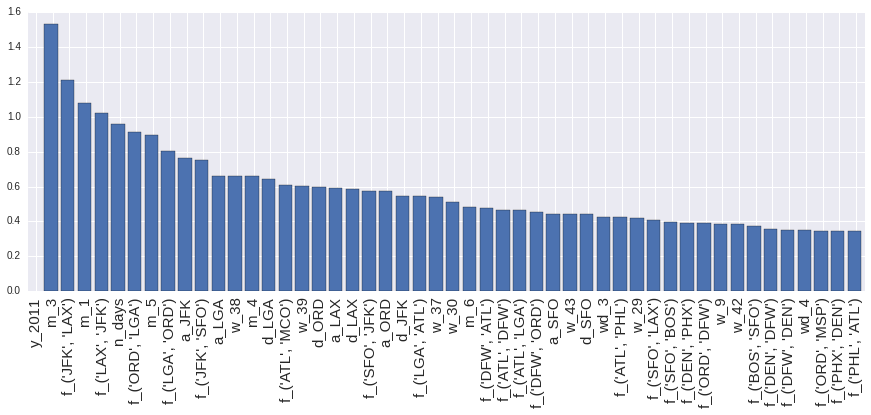

In [21]:
from sklearn.linear_model import LinearRegression
plt.figure(figsize=(15, 5))
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, y_train)
ordering = np.argsort(reg.coef_)[::-1][:50]

importances = reg.coef_[ordering]
#feature_names = X_columns[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x[1:], importances[1:]) #The first one is too big
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [26]:
# Check if some of the tops features are not selected by our feature selector
selected_colums = X_columns[reduc_dim(X_train,y_train)]
ordering = np.argsort(reg.coef_)[::-1][:len(selected_colums)]
feature_names = X_columns[ordering]
for i in range(len(feature_names)):
    if feature_names[i] not in selected_colums:
        print feature_names[i]

y_2011
m_3
w_38
m_4
w_39
w_37
w_30
w_43
w_29
f_('DEN', 'PHX')
w_9
w_42
f_('DEN', 'DFW')
f_('ORD', 'MSP')
f_('PHX', 'DEN')
w_20
f_('LAX', 'SFO')
f_('ORD', 'BOS')
w_17
f_('MCO', 'ATL')
w_18
w_40
f_('ORD', 'EWR')
w_31
w_41
f_('MSP', 'ORD')
w_16
w_8
m_7
w_28
f_('SFO', 'SEA')
f_('LAX', 'ORD')
f_('LAS', 'LAX')
f_('SFO', 'ORD')
d_11
w_34
f_('ORD', 'SFO')
f_('EWR', 'ORD')
wd_6
f_('LAS', 'DEN')
f_('DEN', 'LAS')
d_7
w_12
f_('BOS', 'ATL')
f_('DEN', 'SEA')
d_12
w_33
d_13


#### Linear regressor and features selection
We noticed before that the features selection we implemented failed to pick the most important features.

However we where still wanted to check the impact on RMSE. So we noticed that features selection makes the RMSE increase from 0.5388 to 0.5626


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

reg = LinearRegression(fit_intercept=False)
X_new = X_train[:,reduc_dim(X_train,y_train)]
scores = cross_val_score(reg, X_new, y_train, cv=5, scoring='mean_squared_error')
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.5626 +/-0.0259


### Non Linear Models
We also tested differents non linear models. We picked the best parameters using gridsearch.

It is not visible bellow but the gradient boosting outperformed the Random Forest when we increased the number of trees to hundreds. I was then our best model
#### Random Forests

In [35]:
%%time
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=30,max_features=55,random_state=40)

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.4149 +/-0.0207
CPU times: user 148 ms, sys: 60 ms, total: 208 ms
Wall time: 14.5 s


#### Gradient Boosting tree

In [37]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(n_estimators=30,max_depth=9,random_state=40)

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.4563 +/-0.0155


#### ExtraTreesRegressor

In [41]:
%%time
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=50,random_state=40)

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.4170 +/-0.0154
CPU times: user 800 ms, sys: 576 ms, total: 1.38 s
Wall time: 7min 51s


#### Adaboost of random forest (not useful)

In [42]:
%%time
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
reg = AdaBoostRegressor(RandomForestRegressor(n_estimators=30,max_features=55,random_state=40),n_estimators=10)

scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='mean_squared_error',n_jobs=3)
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.4072 +/-0.0206


#### Coefficients selected (we took a random forest as it trained faster than the others)

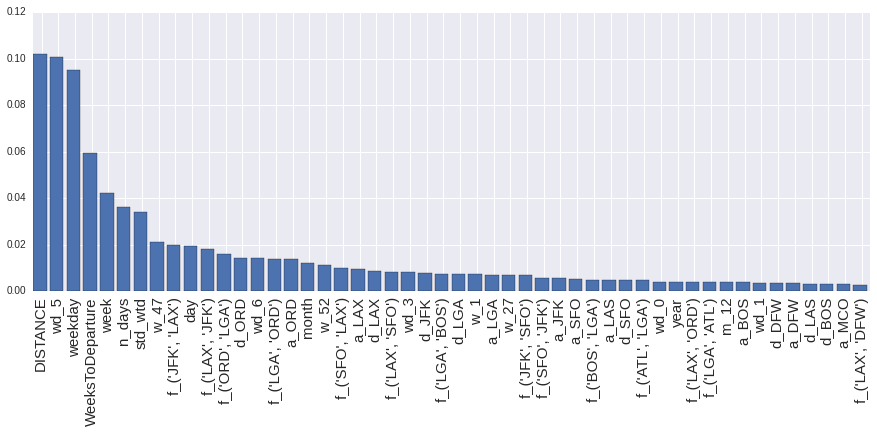

In [43]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(n_estimators=30,max_features=55,random_state=40)
plt.figure(figsize=(15, 5))
reg.fit(X_train, y_train)
ordering = np.argsort(reg.feature_importances_)[::-1][:50]

importances = reg.feature_importances_[ordering]
#feature_names = X_columns[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x[:], importances[:])
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [44]:
# Check if some of the tops features are not selected by our feature selector
selected_colums = X_columns[reduc_dim(X_train,y_train)]
ordering = np.argsort(reg.feature_importances_)[::-1][:len(selected_colums)]
feature_names = X_columns[ordering]
for i in range(len(feature_names)):
    if feature_names[i] not in selected_colums:
        print feature_names[i]

wd_6
f_('LAX', 'SFO')
f_('LGA', 'BOS')
f_('BOS', 'LGA')
wd_0
year
f_('LAX', 'ORD')
a_MCO
f_('LAX', 'DFW')
a_DEN
f_('DFW', 'LAX')
f_('SFO', 'ORD')
f_('ORD', 'LAX')
d_EWR
y_2013
a_PHL
f_('ORD', 'SFO')
a_EWR
d_23
d_24
w_21
d_PHL
y_2011
d_25
f_('ORD', 'MSP')
f_('ORD', 'BOS')
d_3
d_MCO
f_('DTW', 'ORD')
m_3
m_2
m_7


#### Ramdom forest + Features selection
we noticed that RMSE also increases when we performed features selection, from 0.4149 to 0.4179.

For those reasons the feature selection was removed in our last submission

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score

reg = RandomForestRegressor(n_estimators=30,max_features=55,random_state=40)
X_new = X_train[:,reduc_dim(X_train,y_train)]
scores = cross_val_score(reg, X_new, y_train, cv=5, scoring='mean_squared_error')
print("log RMSE: {:.4f} +/-{:.4f}".format(
    np.mean(np.sqrt(-scores)), np.std(np.sqrt(-scores))))

log RMSE: 0.4179 +/-0.0186


### Ensemble Model
We decide to make a global prdiction that will be a combination of the predictions of all the models presented above. To create the ensemble model, we decided to use a SVR.

The score of the ensemble model is shown below (we took parameters that will run fast but with no accuracy)

This ensemble model was then able to improve a little bit the score obtained with our best model: We decrease RMSE from 0.439 to 0.385

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
models = [RandomForestRegressor(n_estimators=10,max_features=55,random_state=40),
          GradientBoostingRegressor(n_estimators=20, max_depth=8, min_samples_split=30, random_state=50),
          ExtraTreesRegressor(n_estimators=10, random_state=60),
          Lasso(alpha= 0.001),
          Ridge(alpha= 0.01),
          LinearRegression(fit_intercept=False)]
clf = SVR(kernel='linear')
# Models training
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
y_pred = np.zeros([X_test2.shape[0],len(models)])
for i in range(len(models)):
    model = models[i]
    model.fit(X_train2, y_train2)
    y_pred[:,i] = model.predict(X_test2)
print "Models scores :"
print [np.sqrt(np.mean(np.square(y_pred[:,i] - y_test2))) for i in range(y_pred.shape[1])]

clf.fit(y_pred, y_test2)

#Model testing
y_pred = np.zeros([X_test.shape[0],len(models)])
for i in range(len(models)):
    model = models[i]
    y_pred[:,i] = model.predict(X_test)
y_final = clf.predict(y_pred)
print "Ensemble Model scores :"
print np.sqrt(np.mean(np.square(y_final - y_test)))

Models scores :
[0.43872725209161156, 0.5431664270157136, 0.44568428384206321, 0.53774447610978393, 0.52745222444870432, 0.52545236969931697]
Ensemble Model scores :
0.384636289297


## Evaluation
The evaluation of the different models was shown in this report. It was performed using cross-validation 

The last submission of the ensemble model help us achieve a RMSE of 0.334 on the public dataset (locally) and on the private dataset

In [34]:
from sklearn.learning_curve import learning_curve


def plot_learning_curve(estimator, X, y, ylim=(0, 0.7), cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),
                        scoring=None):
    plt.title("Learning curves for %s" % type(estimator).__name__)
    plt.ylim(*ylim); plt.grid()
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring)
    train_scores = np.sqrt(-1*train_scores)
    test_scores = np.sqrt(-1*test_scores)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    print("Best test score: {:.4f}".format(test_scores_mean[-1]))

Best test score: 0.4215


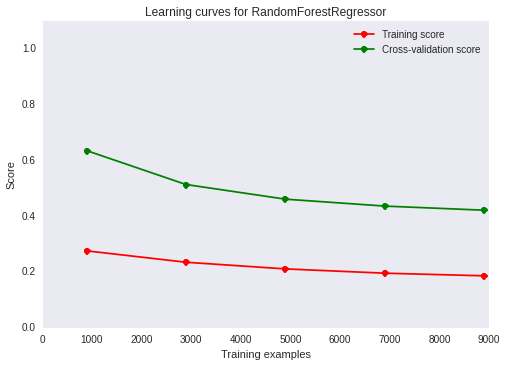

In [35]:
reg = RandomForestRegressor(n_estimators=10,max_features=55,random_state=40)
plot_learning_curve(reg, X, y, ylim=(0, 1.1), cv=5, train_sizes=np.linspace(.1, 1.0, 5),scoring='mean_squared_error')

Best test score: 0.5290


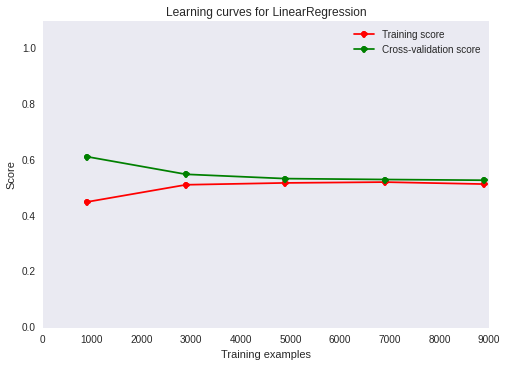

In [36]:
reg = LinearRegression(fit_intercept=False)
plot_learning_curve(reg, X, y, ylim=(0, 1.1), cv=5, train_sizes=np.linspace(.1, 1.0, 5),scoring='mean_squared_error')

## Conclusion

This analysis let me very optimistic for the next submission, as we will test our models on bigger data. So if the learning curves are corrects, we will have more accurate models (learning curves for the differents models presented will look the same)

In [28]:
## Youssef data
yous = pd.read_csv(os.path.join(path, "Submission/youcef_external_data.csv"))
# yous.head()
# data3 = pd.merge(data2,yous,how='left', on=['DateOfDeparture','Arrival','Departure'])
# data3.describe()
# No missing values
# path = '.'
# dist_df = pd.read_csv(os.path.join(path, "Submission/dist_data.csv"))
# dist_df = dist_df.drop_duplicates()
# dist_df = dist_df.rename(columns={'ORIGIN': 'Departure', 'DEST': 'Arrival'})
# X_weather = pd.read_csv(os.path.join(path, "Submission/external_data2.csv"))
# # X_weather = X_weather[['Date', 'AirPort', 'Dew PointC','Max Humidity']]
# X_weather = X_weather[['Date', 'AirPort', 'Max VisibilityKm']]
# X_weather = X_weather.rename(columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
# ext_df = pd.merge(dist_df,X_weather,how='inner', on=['Arrival'])
# ext_df2 = pd.merge(ext_df,yous,how='left', on=['DateOfDeparture','Arrival','Departure'])
# ext_df2.head()

ext_df2.to_csv("Submission/external_data.csv",index=False)

ext_df = pd.read_csv(os.path.join(path, "Submission/external_data.csv"))
ext_df.head()
data2 = pd.merge(data,ext_df,how='left', on=['DateOfDeparture','Arrival','Departure'])
data2 = preprocess(data2)
data_encoded = encode_data(data2)
print data_encoded.shape
data_encoded.tail(5)

(11128, 290)


,WeeksToDeparture,log_PAX,std_wtd,DISTANCE,Max VisibilityKm,Mean,Mean_STD,Distance,oil_price,Total_passenger_number,Domestic_Tourist_Rank,Month,Mean_Month,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,"f_('ATL', 'BOS')","f_('ATL', 'CLT')","f_('ATL', 'DEN')","f_('ATL', 'DFW')","f_('ATL', 'DTW')","f_('ATL', 'EWR')","f_('ATL', 'LAX')","f_('ATL', 'LGA')","f_('ATL', 'MCO')","f_('ATL', 'MIA')","f_('ATL', 'MSP')","f_('ATL', 'ORD')","f_('ATL', 'PHL')","f_('ATL', 'SFO')","f_('BOS', 'ATL')","f_('BOS', 'EWR')","f_('BOS', 'LAX')","f_('BOS', 'LGA')","f_('BOS', 'ORD')","f_('BOS', 'PHL')","f_('BOS', 'SFO')","f_('CLT', 'ATL')","f_('CLT', 'LGA')","f_('DEN', 'ATL')","f_('DEN', 'DFW')","f_('DEN', 'LAS')","f_('DEN', 'LAX')","f_('DEN', 'MSP')","f_('DEN', 'ORD')","f_('DEN', 'PHX')","f_('DEN', 'SEA')","f_('DEN', 'SFO')","f_('DFW', 'ATL')","f_('DFW', 'BOS')","f_('DFW', 'DEN')","f_('DFW', 'LAS')","f_('DFW', 'LAX')","f_('DFW', 'LGA')","f_('DFW', 'ORD')","f_('DFW', 'PHL')","f_('DFW', 'SFO')","f_('DTW', 'ATL')","f_('DTW', 'LGA')","f_('DTW', 'ORD')","f_('EWR', 'ATL')","f_('EWR', 'BOS')","f_('EWR', 'LAX')","f_('EWR', 'MCO')","f_('EWR', 'ORD')","f_('EWR', 'SFO')","f_('IAH', 'LAX')","f_('IAH', 'ORD')","f_('JFK', 'LAS')","f_('JFK', 'LAX')","f_('JFK', 'MCO')","f_('JFK', 'MIA')","f_('JFK', 'SFO')","f_('LAS', 'DEN')","f_('LAS', 'DFW')","f_('LAS', 'JFK')","f_('LAS', 'LAX')","f_('LAS', 'ORD')","f_('LAS', 'SFO')","f_('LAX', 'ATL')","f_('LAX', 'BOS')","f_('LAX', 'DEN')","f_('LAX', 'DFW')","f_('LAX', 'EWR')","f_('LAX', 'IAH')","f_('LAX', 'JFK')","f_('LAX', 'LAS')","f_('LAX', 'ORD')","f_('LAX', 'SEA')","f_('LAX', 'SFO')","f_('LGA', 'ATL')","f_('LGA', 'BOS')","f_('LGA', 'CLT')","f_('LGA', 'DFW')","f_('LGA', 'DTW')","f_('LGA', 'MIA')","f_('LGA', 'ORD')","f_('MCO', 'ATL')","f_('MCO', 'EWR')","f_('MCO', 'PHL')","f_('MIA', 'ATL')","f_('MIA', 'JFK')","f_('MIA', 'LGA')","f_('MSP', 'ATL')","f_('MSP', 'DEN')","f_('MSP', 'ORD')","f_('ORD', 'ATL')","f_('ORD', 'BOS')","f_('ORD', 'DEN')","f_('ORD', 'DFW')","f_('ORD', 'DTW')","f_('ORD', 'EWR')","f_('ORD', 'IAH')","f_('ORD', 'LAS')","f_('ORD', 'LAX')","f_('ORD', 'LGA')","f_('ORD', 'MSP')","f_('ORD', 'PHL')","f_('ORD', 'PHX')","f_('ORD', 'SEA')","f_('ORD', 'SFO')","f_('PHL', 'ATL')","f_('PHL', 'BOS')","f_('PHL', 'DFW')","f_('PHL', 'MCO')","f_('PHL', 'ORD')","f_('PHX', 'DEN')","f_('PHX', 'ORD')","f_('SEA', 'DEN')","f_('SEA', 'LAX')","f_('SEA', 'ORD')","f_('SEA', 'SFO')","f_('SFO', 'ATL')","f_('SFO', 'BOS')","f_('SFO', 'DEN')","f_('SFO', 'DFW')","f_('SFO', 'EWR')","f_('SFO', 'JFK')","f_('SFO', 'LAS')","f_('SFO', 'LAX')","f_('SFO', 'ORD')","f_('SFO', 'SEA')",year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
11123,0.060392,-0.664604,0.118008,0.450964,0.100576,0.764086,0.911947,0.450929,0.576933,-0.677272,-0.744155,1.082049,-0.214994,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2011,11,22,1,47,15300,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0